# 1 Making the reference catalogues


We need a photometric and astrometric reference. We are going to take the HSC PanSTARRS reference as a base and cross match in the VIKING ZYJHKs fluxes from HELP. 


The final astrometric reference catalogue will probably be GAIA DR2 astrometry and PanSTARSS plus either 2MASS or the original VISTA catalogues.

In the readme we discuss the changes that have been made to the required format over time. This notebook should show the various changes that we make here including converting fluxes to magnitudes and cross matching in the NIR.



After this has been done these reference catalogues must be ingested according to the instructions given in the DMU2 readme.

In [1]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import glob
from collections import OrderedDict

In [2]:
ORIG = ''
PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/188416.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'



VIKING_CATS = glob.glob('../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking*.fits.gz')

In [3]:
VIKING_CATS

['../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_130_140_2.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_160_170_5.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_220_230_11.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_120_130_1.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_170_180_6.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_210_220_10.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_150_160_4.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_200_210_9.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_230_240_12.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_190_200_8.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra32_38_w02.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_140_150_3.fits.gz',
 '../dmu0/dmu0_VISTA/dmu0_VIKING/data/viking_dr5_ra_180_190_7.fits.gz']

In [4]:
t = Table.read(EX_CAT)

In [5]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
108003593617180435,6.27204837905269,-1.7810517259552775e-06,0,9.550021786708385e-07,5.0367061703582294e-06,1.1320298654027283e-05,1.6851623513503e-05,2.1093712348374538e-05,5.097311941426597e-07,6.661442739641643e-07,3.404337576284888e-07,1.01842397270957e-06,1.2752344673572225e-06,0.0,0.0,1350001664,0.045981944,-0.043275457,0.034188043,0.034992907,0
107243599285956015,6.281939567078114,-0.01097539115627658,0,2.168949549741228e-06,4.778848506248323e-06,7.449491931765806e-06,1.3767468772130087e-05,1.9005747162736952e-05,3.657194724837609e-07,2.878014811358298e-06,2.7497526389197446e-07,1.5068798120410065e-06,3.1472012551603257e-07,0.0,0.0,1343807360,-0.06615359,-0.07740473,0.045893095,0.043096416,0
107233599379614290,6.282102758441709,-0.011144414345660884,0,2.3593809146404965e-06,1.6378801319660852e-06,2.9821883344993694e-06,6.162106274132384e-06,1.3584878615802154e-05,3.17906142299762e-07,2.2089609501563245e-06,3.794208396357135e-07,1.0178830507356906e-06,6.186981522660062e-07,0.0,0.0,1350889856,0.0,0.0,0.0,0.0,0
107223599413767784,6.282162404896845,-0.011239285087807067,0,3.910203759005526e-06,2.1229448066151235e-06,3.786871047850582e-06,5.439698270492954e-06,1.0658537576091476e-05,3.724599366705661e-07,2.33082960221509e-06,2.8468625146160775e-07,8.323602855853096e-07,1.7325971839454724e-06,0.0,0.0,1349434880,0.0,0.0,0.0,0.0,0
107223599465252718,6.2822490248996266,-0.011310071884075951,0,1.2273228549020132e-06,2.072620645776624e-06,2.9194793569331523e-06,5.422667072707554e-06,9.84519374469528e-06,4.909048243462166e-07,4.1293610593129415e-06,2.2009579936366208e-07,8.837623681756668e-07,3.434489599385415e-07,0.0,0.0,1330325888,0.0,0.0,0.0,0.0,0


In [6]:
def getShards(ra, dec, radius=1.):
    """Take a region defined by four corners and return shard ids
    
    We want every shard id in the region and for now do not 
    mind about having some ids on the boundary that are not in the region
    
    """
    ra_max = np.max(ra)
    ra_min = np.min(ra)
    dec_max = np.max(dec)
    dec_min = np.min(dec)
    
    htm = HtmIndexer(depth=7)
    all_shards = set()
    for radec in np.nditer(np.meshgrid(
        np.linspace(ra_min,ra_max,   num = int(np.ceil((ra_max-ra_min)/radius))),
        np.linspace(dec_min,dec_max, num = int(np.ceil((ra_max-ra_min)/radius)))
    )):
        
        shards, onBoundary = htm.getShardIds(SpherePoint(radec[0]*degrees, radec[1]*degrees), radius*degrees)
        all_shards = all_shards.union(set(shards))
    return all_shards
ps_refcats = getShards([33.,38.],  [-7,-2])
#ps_refcats

In [7]:
shards_wide = set()
for f in VIKING_CATS:
    t = Table.read(f)['RA', 'DEC']
    t['RA'].unit = u.rad
    t['DEC'].unit = u.rad
    t['RA'].convert_unit_to(u.deg)
    t['DEC'].convert_unit_to(u.deg)
    shards_wide = shards_wide.union(getShards(t['RA'],t['DEC']))
    
print(len(ps_refcats), len(shards_wide))

208 3674


In [8]:
ps_refcats = shards_wide

In [9]:
#SCP to download everything you need for the VIKING/HSC Wide overlap - this breaks most shells
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/{'
      +files[:-1]+'} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/{155648.fits,163841.fits,155650.fits,155649.fits,163844.fits,155653.fits,163846.fits,163847.fits,155656.fits,155657.fits,155658.fits,155659.fits,155660.fits,155661.fits,155654.fits,155663.fits,163856.fits,163857.fits,163858.fits,163859.fits,155668.fits,155666.fits,155670.fits,155671.fits,163864.fits,163865.fits,163866.fits,163867.fits,163868.fits,155669.fits,163870.fits,155675.fits,155680.fits,155681.fits,155676.fits,155683.fits,155684.fits,155685.fits,155686.fits,155678.fits,155688.fits,155682.fits,155690.fits,155691.fits,155687.fits,155693.fits,155694.fits,155695.fits,155696.fits,155689.fits,155698.fits,155692.fits,155700.fits,155701.fits,155697.fits,155699.fits,155703.fits,163896.fits,155704.fits,163897.fits,163898.fits,163899.fits,155705.fits,155706.fits,155712.fits,155713.fits,155714.fits,155715.fits,155716.fits,155717.fits,155718.fits,155719.fits,155720.fits,15

In [10]:
#CP to download everything you need for the VIKING/HSC Wide overlap
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
with open('../dmu0/dmu0_PanSTARRS/copy_viking_hsc.sh', 'w') as the_file:
    the_file.write('#!/bin/bash\n')
    the_file.write('# This copies only the shards required to make the VIKING/HSC refcats\n')
    the_file.write('mkdir -p ./data/viking_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('cp ./data/ps1_pv3_3pi_20170110/{'
      +files[:-1]+'} ./data/viking_hsc_subset_ps1_pv3_3pi_20170110/\n')
    the_file.write('tar -czvf ./data/viking_hsc_subset_ps1_pv3_3pi_20170110.tar.gz ./data/viking_hsc_subset_ps1_pv3_3pi_20170110/\n')



In [11]:
#then scp 
#scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/viking_hsc_subset_ps1_pv3_3pi_20170110.tar.gz .
#tar -xvf

In [12]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [13]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
vega_to_ab = {
    "z2":0.502 + 0.004,
    "y2":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [14]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "id",
        'RA': "ra",
        'DEC': "dec",
        'PSTAR':  "stellarity",
        'ZAPERMAG3': "m_ap_vista_z2", 
        'ZAPERMAG3ERR': "merr_ap_vista_z2",
    
        'YAPERMAG3': "m_ap_vista_y2", 
        'YAPERMAG3ERR': "merr_ap_vista_y2",

        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        

        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        

        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })


#catalogue = Table.read(VIKING_CAT)[list(imported_columns)]
catalogue = Table()

for c in VIKING_CATS:
    catalogue = vstack([catalogue,Table.read(c)[list(imported_columns)]])
for column in imported_columns:
    new_col = 'viking_' + imported_columns[column]
    catalogue[column].name = new_col
    
for col in catalogue.colnames:
    if col.startswith('viking_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        catalogue[col][mask] = np.nan
        catalogue[col.replace('viking_m', 'viking_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmedian(catalogue[col])
        catalogue[col] += vega_to_ab[col.split('_')[-1]]
        print(col, vega_to_ab[col.split('_')[-1]], np.nanmedian(catalogue[col])-before)

v_flux = catalogue[catalogue['viking_stellarity'] >= 0.9]

/Users/raphaelshirley/Documents/github/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/numpy/lib/function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


viking_m_ap_vista_z2
viking_m_ap_vista_z2 0.506 0.5060005187988281
viking_m_ap_vista_y2
viking_m_ap_vista_y2 0.578 0.5779991149902344
viking_m_ap_vista_j
viking_m_ap_vista_j 0.916 0.9160003662109375
viking_m_ap_vista_h
viking_m_ap_vista_h 1.385 1.385000228881836
viking_m_ap_vista_ks
viking_m_ap_vista_ks 1.816 1.815999984741211


In [15]:
v_flux[:5]

viking_id,viking_ra,viking_dec,viking_stellarity,viking_m_ap_vista_z2,viking_merr_ap_vista_z2,viking_m_ap_vista_y2,viking_merr_ap_vista_y2,viking_m_ap_vista_j,viking_merr_ap_vista_j,viking_m_ap_vista_h,viking_merr_ap_vista_h,viking_m_ap_vista_ks,viking_merr_ap_vista_ks
,RADIANS,RADIANS,,,,,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
601385440656,2.3446097674794344,0.046466699632350415,0.97674423,21.080187,0.04513199,20.833387,0.07874532,nan,nan,nan,nan,nan,nan
601385440659,2.34461291068286,0.045189408459404015,0.9,22.374708,0.14197652,nan,nan,nan,nan,nan,nan,nan,nan
601385440663,2.344618970494396,0.046217501166384775,0.9,21.891655,0.09209291,nan,nan,nan,nan,nan,nan,nan,nan
601385440665,2.3446213311228647,0.04311124162978301,0.9,21.003157,0.04383819,nan,nan,nan,nan,nan,nan,nan,nan
601385440668,2.344615409144536,0.04370734542689002,0.993865,17.411234,0.003417083,17.132421,0.00539978,nan,nan,nan,nan,nan,nan


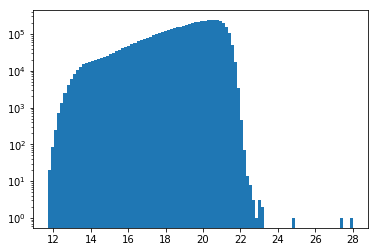

In [16]:
plt.hist(v_flux['viking_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [17]:
np.sum(~np.isnan(v_flux['viking_m_ap_vista_ks']))

5496233

In [18]:
import astropy.units as u

In [19]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [20]:
v_flux['viking_ra'].unit = u.rad
v_flux['viking_dec'].unit = u.rad
v_flux['viking_ra'].convert_unit_to(u.rad)
v_flux['viking_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

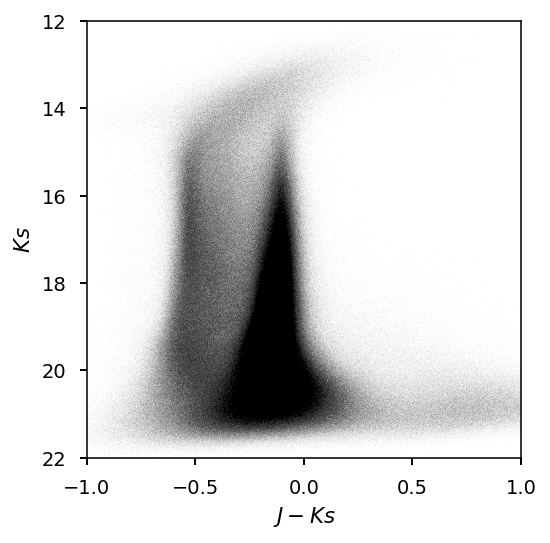

In [21]:

#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['viking_m_ap_vista_j'] - v_flux['viking_m_ap_vista_ks'],
            v_flux['viking_m_ap_vista_ks'],
            edgecolors='None', s=0.005, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(22, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

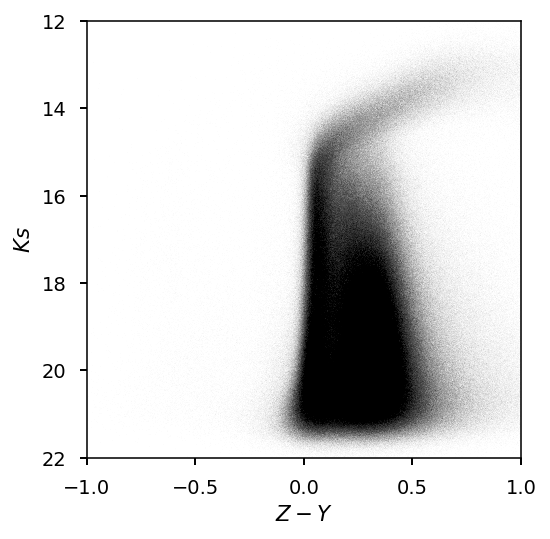

In [22]:
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['viking_m_ap_vista_z2'] - v_flux['viking_m_ap_vista_y2'],
            v_flux['viking_m_ap_vista_ks'],
            edgecolors='None', s=0.005, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(22, 12)
plt.xlabel('$Z-Y$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [23]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [24]:
r_cat = Table.read(EX_CAT)

In [25]:
ref_cats_table = Table()
ref_cats_table['shard'] = [n for n in ps_refcats]
ref_cats_table['objects']=np.full(len(ref_cats_table),-99)
ref_cats_table['vista']=np.full(len(ref_cats_table),-99)

In [26]:
#VIKING REF CAT
!mkdir -p data/ref_cats_viking
n=0
for row in ref_cats_table:
    c=row['shard']
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'viking_ra', 'viking_dec', radius=0.4*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['viking_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )
    merge = merge[has_both]
    row['objects'] = np.sum(has_both)
    row['vista'] = np.sum(merge['viking_m_ap_vista_ks']>0.)
    if np.sum(merge['viking_m_ap_vista_ks']>0.) == 0:
        #print('No VIKING Objects in ', c)
        continue
    n+=1
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every viking mag col and rename
        if col.startswith('viking_m_'):
            merge[col].name =col.split('_')[-1]
            merge[col.replace('viking_m_', 'viking_merr_')].name =  col.split('_')[-1] + '_err'
    if len(merge) == 0:
        print('No Objects in ', c)
        continue
    merge.remove_columns(['viking_stellarity', 'viking_id'])
    merge.write('./data/ref_cats_viking/{}.fits'.format(c), overwrite=True)
    ex=merge.copy()
    #print("Shard {} has {} objects and {} VIKING mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))


In [27]:
ex[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,z2,z2_err,y2,y2_err,j,j_err,h,h_err,ks,ks_err,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
108001958603290448,195.8603587538433,-6.6143461999051e-06,0,23.35297821971079,22.325417980334304,22.040829642191486,22.880108340704087,21.331293519588264,0.06629821624849763,0.1532372431290486,0.0739936566515988,1.349033822497075,0.3311880412333496,0.0,0.0,1381328512,-0.049143523,-0.031489875,0.12042245,0.12042245,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
107211954978958852,195.49790863348778,-0.6512922105512425,0,22.36378900995071,20.894610876190264,20.24382110536746,19.836460378704576,19.667688673201802,0.03203098752278155,0.03551306802239411,0.05416640357496443,0.04179684619229234,0.1351327562141542,0.0,0.0,1333135360,0.004831219,0.011889168,0.010808241,0.013487881,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
107171954994672832,195.49943059947617,-0.6896077241090334,0,22.57585993873356,21.067633618214153,20.433621386362507,19.961427393260717,20.0051641700017,0.027111399716715067,0.0489489136199355,0.039099274979425114,0.053003935048881665,0.10515108117658546,0.0,0.0,1332178560,-0.0042290357,0.012368156,0.026590921,0.032205433,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
107201954995165037,195.49949427397476,-0.662845165110756,0,23.07548759347354,22.384526703007246,22.086570244363095,22.35543012422116,21.748549918406486,0.09008529456408654,0.222913677034666,0.10640172334039781,0.2014010229151973,0.12895889975586533,0.0,0.0,1299764608,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
107171955000984939,195.50012465859513,-0.6879061965685564,0,22.217786309662092,21.441109113779547,21.104836460795873,20.960168816338896,20.96932173069739,0.05105013822892497,0.11211836352172017,0.06576906505307466,0.09455516971444577,0.06268707453787523,0.0,0.0,1322624768,-0.03861737,-0.02964999,0.03870701,0.052179802,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0


In [28]:
ref_cats_table.write('./data/viking_ref_cats_shards.csv',overwrite=True)

In [29]:
np.sum(ref_cats_table['vista']>0)/len(ref_cats_table)

0.7539466521502449